In [52]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN, PPO, TD3, SAC
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


In [53]:
def get_average_fps(event_file, scalar_tag="time/fps"):
    """
    Calculate the average FPS (frames per second) from a TensorBoard event file.
    """
    try:
        # Use EventAccumulator to load the event file
        event_acc = EventAccumulator(event_file)
        event_acc.Reload()

        # Get scalar events for the specified tag
        events = event_acc.Scalars(scalar_tag)
        if not events:
            return None

        # Calculate the average FPS
        fps_values = [event.value for event in events]
        return sum(fps_values) / len(fps_values)
    
    except Exception as e:
        print(f"Error processing event file {event_file}: {e}")
        return None

In [54]:
import re

def clean_environment_name(part):
    # Remove 'seed_XX_' or numeric prefixes followed by '_'
    return re.sub(r"^(seed_\d+_|^\d+_)", "", part)

In [55]:
def find_all_models(log_dir="./logs", algorithms={"ppo": "PPO", "dqn": "DQN", "td3": "TD3", "sac": "SAC"}):
    """Find all model files in the logs directory and extract metadata."""
    models = []
    for root, _, files in os.walk(log_dir):
        zip_files = [f for f in files if f.endswith(".zip")]
        if not zip_files:
            continue

        # Extract metadata from the directory structure
        path_parts = root.split(os.path.sep)
        seed = next((int(part.split("_")[1]) for part in path_parts if part.startswith("seed_")), None)
        environment = next((clean_environment_name(part) for part in path_parts if "-v" in part or "Continuous" in part or "Pendulum" in part), "unknown")
        algorithm = next((algorithms.get(part.lower()) for part in path_parts if part.lower() in algorithms), None)

        if not algorithm:
            continue

        # Get average FPS if event files exist
        event_files = glob.glob(os.path.join(root, f"{algorithm}_1", "events.out.tfevents.*"))
        avg_fps = get_average_fps(event_files[0]) if event_files else None

        # Add model metadata
        for zip_file in zip_files:
            models.append({
                "path": os.path.join(root, zip_file),
                "algorithm": algorithm,
                "environment": environment,
                "seed": seed,
                "best_model": zip_file == "best_model.zip",
                "avg_fps": avg_fps
            })
    return models



In [56]:


def get_stats(models):
    """Get statistics for each model."""
    stats = []
    for model in models:
        try:
            if model["algorithm"] == "PPO":
                loaded_model = PPO.load(model["path"])
            elif model["algorithm"] == "DQN":
                loaded_model = DQN.load(model["path"])
            elif model["algorithm"] == "TD3":
                loaded_model = TD3.load(model["path"])
            elif model["algorithm"] == "SAC":
                loaded_model = SAC.load(model["path"])
            else:
                continue

            policy = loaded_model.policy
            num_params = sum(p.numel() for p in policy.parameters())
            num_layers = len(list(policy.parameters()))
            model_size_kb = os.path.getsize(model["path"]) / 1024
            num_zero_params = sum((p == 0).sum().item() for p in policy.parameters())
            sparsity = num_zero_params / num_params if num_params > 0 else 0
            
            stats.append({
                "algorithm": model["algorithm"],
                "environment": model["environment"],
                "seed": int(model["seed"]),
                "best_model": model['best_model'],
                "model_size_kb": model_size_kb,
                "num_params": num_params,
                "num_layers": num_layers,
                "num_zero_params": num_zero_params,
                "sparsity": sparsity,
                "avg_fps": model.get("avg_fps")
            })
        except Exception as e:
            print(f"Error loading model {model['path']}: {e}")
    return pd.DataFrame(stats)

In [57]:
models = find_all_models(log_dir="./logs")

stats = get_stats(models)


Error processing event file ./logs/PPO/LunarLander-v3/PPO_1/events.out.tfevents.1746957468.MacBook-Pro-de-Elia.local.86065.0: 'Key time/fps was not found in Reservoir'


/Users/elia/anaconda3/envs/ada/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(
/Users/elia/anaconda3/envs/ada/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(
/Users/elia/anaconda3/envs/ada/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(


Error loading model ./logs/PPO/LunarLander-v3/_PPO_LunarLander-v3.zip: int() argument must be a string, a bytes-like object or a number, not 'NoneType'
Error loading model ./logs/PPO/LunarLander-v3/best_model.zip: int() argument must be a string, a bytes-like object or a number, not 'NoneType'


In [58]:
stats.head(3)

,algorithm,environment,seed,best_model,model_size_kb,num_params,num_layers,num_zero_params,sparsity,avg_fps
0,DQN,CartPole-v0,42,True,98.375000,9220,12,0,0.0,3782.186695
1,DQN,CartPole-v0,42,False,98.360352,9220,12,0,0.0,3782.186695
2,PPO,CartPole-v0,42,False,138.788086,9155,12,0,0.0,2787.571429


In [ ]:
# adding parameter ratio
stats['param/size'] =  stats['num_params']  / stats['model_size_kb']
stats['param/size']      

0      93.722999
1      93.736957
2      65.963875
3      65.970838
4      93.723929
         ...    
61    127.073026
62     95.251380
63     95.256701
64     66.748247
65     66.766016
Name: param/size, Length: 66, dtype: float64

In [75]:

model_size_table = stats.pivot_table(
    index="environment",  
    columns="algorithm",  
    values="model_size_kb", 
    aggfunc="mean"  
)


model_size_table = model_size_table.reset_index()
model_size_table = model_size_table.round(1)

model_size_table

algorithm,environment,DQN,PPO,SAC,TD3
0,Acrobot-v1,99.2,140.9,NaN,NaN
1,CartPole-v0,98.4,138.8,NaN,NaN
2,LunarLander-v3,104.9,146.7,NaN,NaN
3,LunarLanderContinuous-v3,NaN,NaN,3005.8,5893.6
4,Pendulum,NaN,137.0,2937.7,5781.6


In [76]:

fps_table = stats.pivot_table(
    index="environment",  
    columns="algorithm", 
    values="avg_fps",  
    aggfunc="mean"  
)


fps_table = fps_table.reset_index()

fps_table = fps_table.round(1)


fps_table

algorithm,environment,DQN,PPO,SAC,TD3
0,Acrobot-v1,1444.1,1036.5,NaN,NaN
1,CartPole-v0,3923.8,2810.9,NaN,NaN
2,LunarLander-v3,1487.2,1716.1,NaN,NaN
3,LunarLanderContinuous-v3,NaN,NaN,152.6,249.7
4,Pendulum,NaN,2141.9,250.2,315.0


In [77]:

params_table = stats.pivot_table(
    index="environment",  
    columns="algorithm", 
    values="param/size",  
    aggfunc="mean"  #
)


params_table = fps_table.reset_index()
params_table = fps_table.round(1)


params_table

algorithm,environment,DQN,PPO,SAC,TD3
0,Acrobot-v1,1444.1,1036.5,NaN,NaN
1,CartPole-v0,3923.8,2810.9,NaN,NaN
2,LunarLander-v3,1487.2,1716.1,NaN,NaN
3,LunarLanderContinuous-v3,NaN,NaN,152.6,249.7
4,Pendulum,NaN,2141.9,250.2,315.0


In [78]:

def save_table_as_image(
    table: pd.DataFrame,
    filename: str = "table.pdf",
    title: str = "Table",
    fontsize: int = 10,
    dpi: int = 300,
):
    """
    Render `table` as a high-resolution table graphic and save to *filename*.

    • Row maximum is printed in **bold**.  
    • Missing values appear as “*”.  
    • The top-left corner cell is labeled “environment”.
    """
    # ── Data prep ─────────────────────────────────────────────────────────
    tbl = table.copy()
    if "environment" in tbl.columns:
        tbl = tbl.set_index("environment")

    # create a display version: numbers → 1 dec place, NaNs → '*'
    display_tbl = (
        tbl.round(1)
           .astype(object)
           .where(~tbl.isna(), "*")
    )

    n_rows, n_cols = display_tbl.shape

    # ── Figure geometry scales with table size ───────────────────────────
    cell_w, cell_h = 1.4, 0.5
    fig_w = max(cell_w * (n_cols + 1), 6)       # +1 for index column
    fig_h = max(cell_h * (n_rows + 1.5), 4)     # +1.5 for title space

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.axis("off")

    # ── Build the table ──────────────────────────────────────────────────
    table_obj = ax.table(
        cellText=display_tbl.values,
        rowLabels=display_tbl.index.tolist(),
        colLabels=display_tbl.columns.tolist(),
        loc="center",
        cellLoc="center",
    )
    table_obj.scale(1.2, 1.2) 

    # ── Style cells, headers, and corner ─────────────────────────────────
    for (r, c), cell in table_obj.get_celld().items():
        if r == 0 or c == -1:                          
            cell.set_text_props(fontweight="bold", fontsize=fontsize + 2)
            cell.set_facecolor("#F0F0F0")
        else:
            # bold the row maximum (ignore NaNs)
            numeric_row = tbl.iloc[r - 1]
            if not numeric_row.isna().all():
                if tbl.columns[c] == numeric_row.idxmax():
                    cell.set_text_props(fontweight="bold")
            cell.set_text_props(fontsize=fontsize)


    if (0, -1) in table_obj.get_celld():
        corner = table_obj[(0, -1)]
        corner.get_text().set_text("environment")
        corner.set_text_props(fontweight="bold", fontsize=fontsize + 2)
        corner.set_facecolor("#F0F0F0")


    fig.tight_layout()
    plt.show()
    fig.savefig(filename, bbox_inches="tight")  
    plt.close(fig)




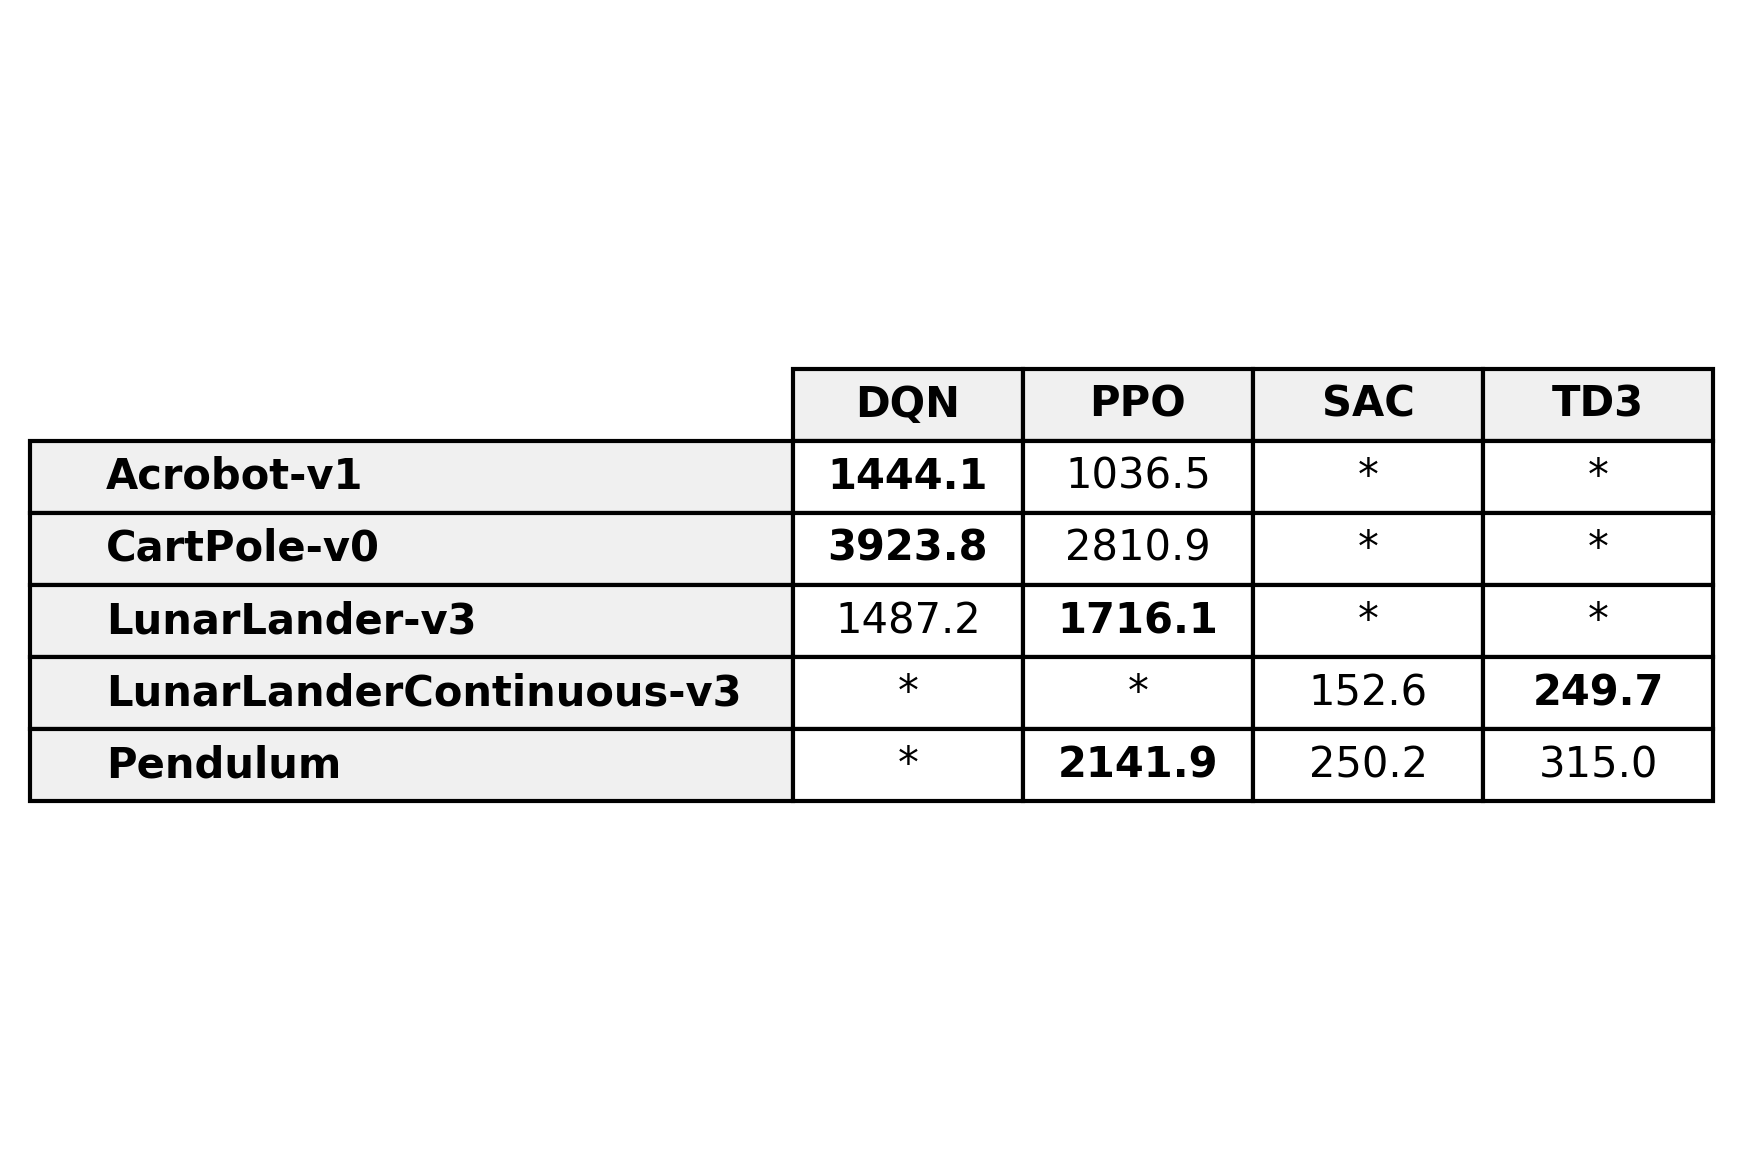

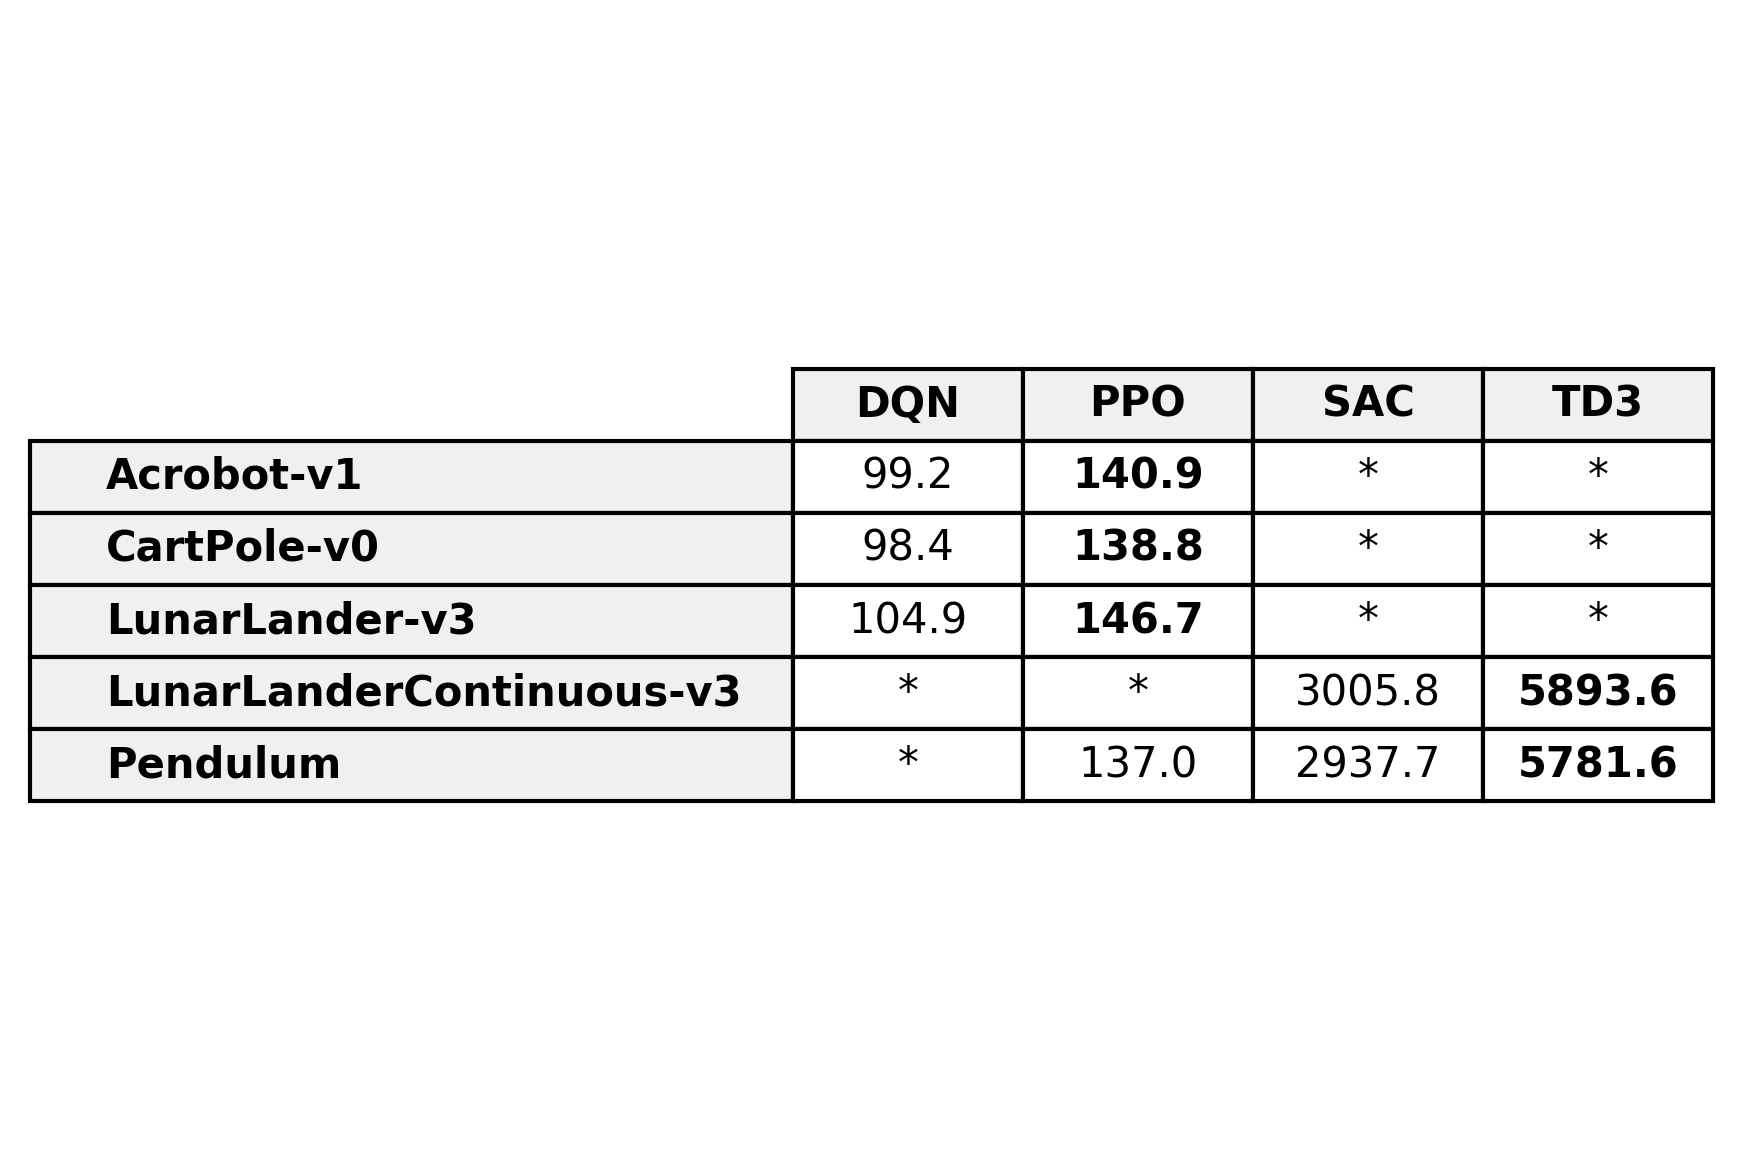

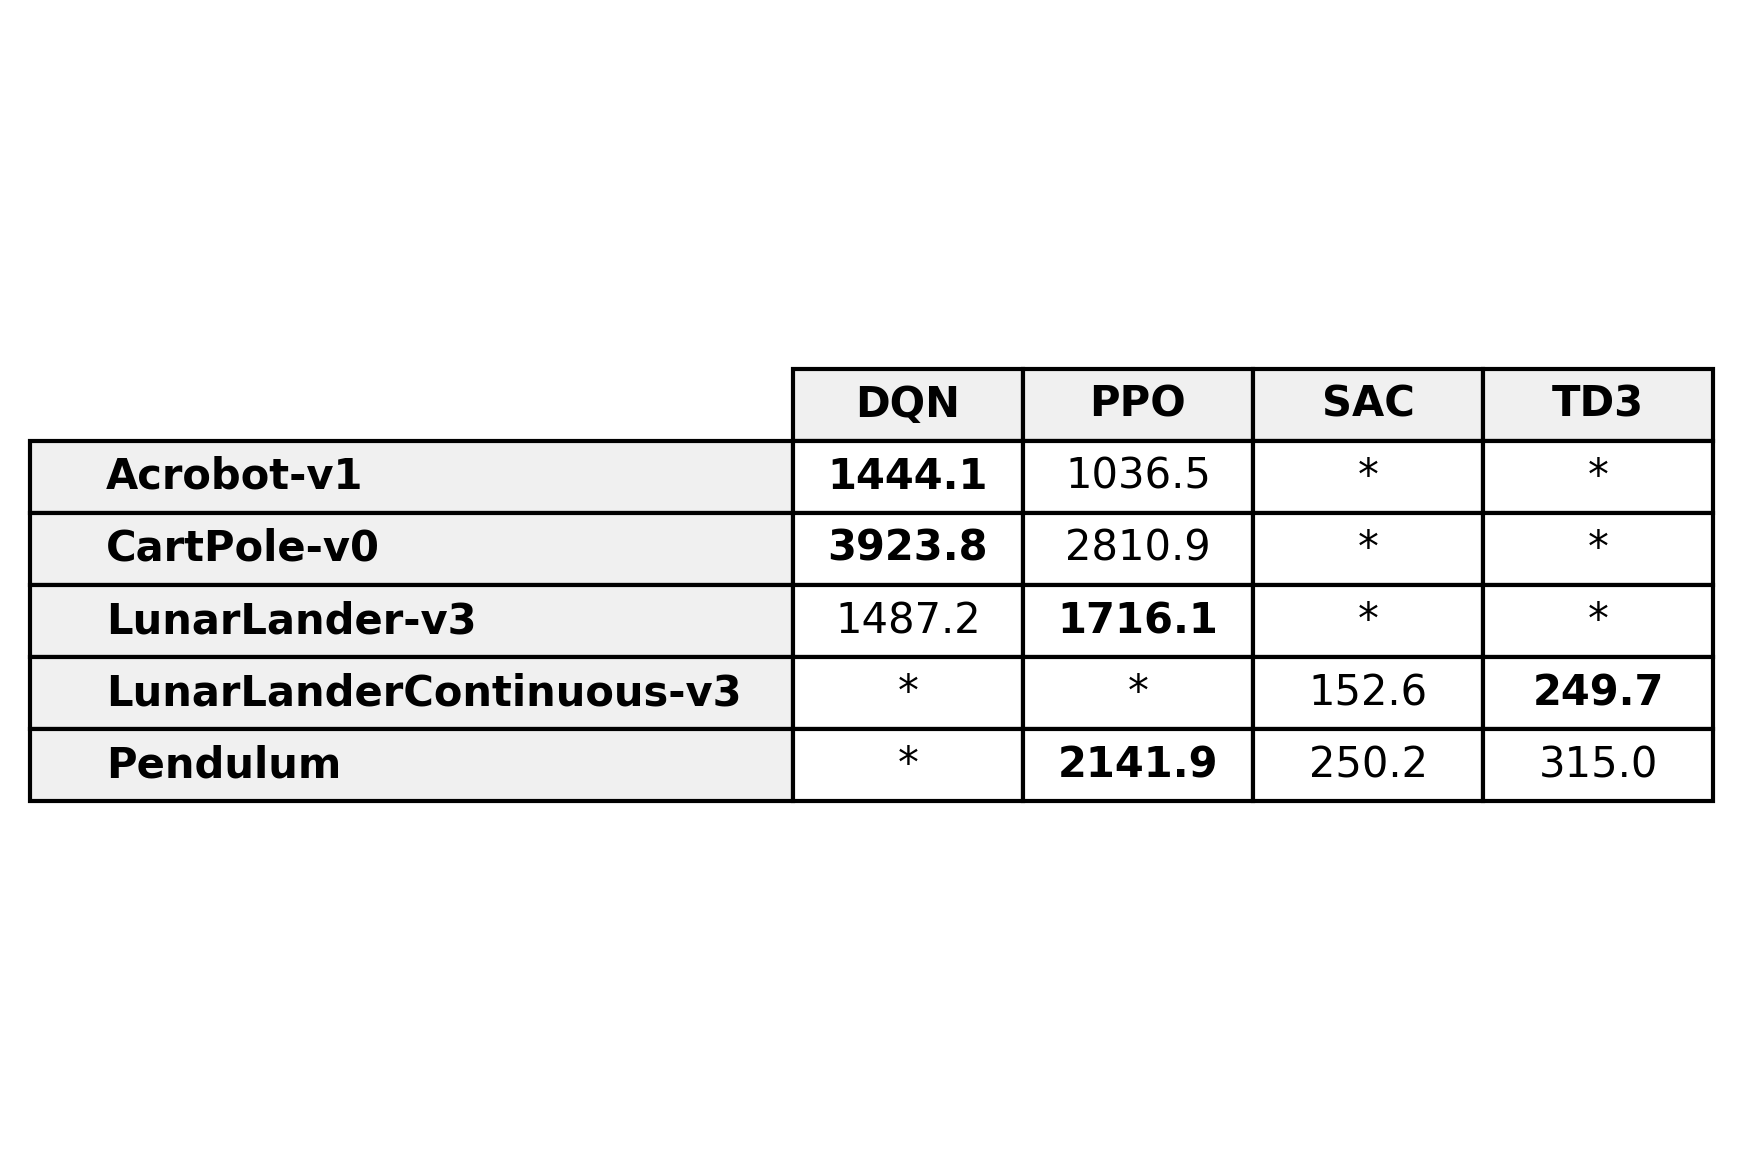

In [80]:

save_table_as_image(fps_table, filename="fps_table.pdf",
                     title="Average FPS per Environment")
save_table_as_image(model_size_table, filename="model_size_table.pdf",
                     title="Model Size per Environment")    
save_table_as_image(params_table, filename="params_table.pdf", 
                     title="Parameter Size per Environment")        